# Machine Learning Geostrophic Balance

By Ryan Abernathey.

Adapted from Ph.D. work by Anirban Sinha.

Sinha, Anirban. _Temporal Variability in Ocean Mesoscale and Submesoscale Turbulence_. Columbia University, 2019. https://doi.org/10.7916/d8-bngk-r215

## Geostrophic Balance
Geostrophic balance describes the relationship between pressure gradients and winds / currents. At the ocean surface, it is expressed as:

$$
\begin{align}
u &= - \frac{g}{f} \frac{\partial \eta}{\partial y} \\
v &= \frac{g}{f} \frac{\partial \eta}{\partial x}
\end{align}
$$

where $\eta$ is the sea surface height relative to the geoid, $g$ is gravitational acceleration, and $f = 2 \Omega \sin(\lambda)$ is the [Coriolis frequency](https://en.wikipedia.org/wiki/Coriolis_frequency). The coordinates $x$ and $y$ are local cartesian coordinates for the zonal and meridional directions, and $u$ and $v$ are the corresponding velocity components.

To calculate geostrophic balance from gridded data, we usually use some kind of finite difference scheme. The details of how this is implemented depend on the nature of the dataset--observations vs. model, C-grid, B-grid, etc.--but the general idea is that we will use some sort of n-point _stencil_ in the neighborhood around the point of interest. Larger $n$ corresponds with higherer order numerical schemes. The simplest centered-difference scheme involves a 3x3 stencil.

So we can think of geostrophic balance as model which takes as its inputs:
- sea surface height $\eta$
- position (needed for derivatives and Coriolis parameter)
On a 3x3 stencil and returns $u$ and $v$.

The problem is nonlinear on the sphere because $f$, $dx$, and $dy$ all vary in space.

**Can we teach a neural network to do this?**

![local stencil](local_stencil_machine_learning.svg)

We hypothesize that this is a good test problem for more ambitious machine learning related to subgrid parameterization.
So what is the most efficient architecture for this sort of problem?

In this notebook, we use two different approaches.

1. Generate the stencil manually as a post-processing step, and then use a fully-connected neural network on each point individually. **Works!**
1. Use a 2D CNN to create the stencil, followed by 1x1 convolution layers. **Doesn't work!**

The big question I have for anyone reading this is _why doesn't approach 2 work?_

In [1]:
import xarray as xr
import gcsfs
from glob import glob
from dask.diagnostics import ProgressBar, Profiler
import dask
import os
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import random

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
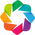

In [2]:
import holoviews as hv
from holoviews import opts
from holoviews.operation.datashader import datashade, shade, dynspread, rasterize
import datashader
hv.extension('bokeh')

In [3]:
import keras
import tensorflow as tf

Using TensorFlow backend.
/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/srv/conda/envs/notebook/lib/python3.7/site-packag

We will use [xbatcher](https://xbatcher.readthedocs.io/en/latest/), a new library we are developing to help with xarray -> deep learning pipelines.

In [4]:
from xbatcher import BatchGenerator

## CESM Ocean GCM Dataset

We will use data from a high-resolution CESM POP ocean model simulation. 

In [5]:
import intake
cat_url = 'https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/master.yaml'
cat = intake.Catalog(cat_url)
ds = cat.ocean.CESM_POP.CESM_POP_hires_control.to_dask()
ds

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)
/srv/conda/envs/notebook/lib/python3.7/site-packages/fsspec/implementations/local.py:32: FutureWarning: The default value of auto_mkdir=True has been deprecated and will be changed to auto_mkdir=False by default in a future release.
  FutureWarning,


<xarray.Dataset>
Dimensions:             (nlat: 2400, nlon: 3600, time: 14965, z_t: 62, z_t_150m: 15, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
    ANGLE               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ANGLET              (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HT                  (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HTE                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HTN                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HU                  (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HUS                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HUW                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    KMT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    KMU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    REGION_MASK         (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    T0_Kelvin           float64 ...
    TAREA               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLAT                (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLONG               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    UAREA               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ULAT                (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ULONG               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    cp_air              float64 ...
    cp_sw               float64 ...
    days_in_norm_year   timedelta64[ns] ...
    dz                  (z_t) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    dzw                 (z_w) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    fwflux_factor       float64 ...
    grav                float64 ...
    heat_to_PW          float64 ...
    hflux_factor        float64 ...
    latent_heat_fusion  float64 ...
    latent_heat_vapor   float64 ...
    mass_to_Sv          float64 ...
    momentum_factor     float64 ...
    nsurface_t          float64 ...
    nsurface_u          float64 ...
    ocn_ref_salinity    float64 ...
    omega               float64 ...
    ppt_to_salt         float64 ...
    radius              float64 ...
    rho_air             float64 ...
    rho_fw              float64 ...
    rho_sw              float64 ...
    salinity_factor     float64 ...
    salt_to_Svppt       float64 ...
    salt_to_mmday       float64 ...
    salt_to_ppt         float64 ...
    sea_ice_salinity    float64 ...
    sflux_factor        float64 ...
    sound               float64 ...
    stefan_boltzmann    float64 ...
  * time                (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:00:00
    vonkar              float64 ...
  * z_t                 (z_t) float32 500.0 1500.0 ... 562499.06 587499.06
  * z_t_150m            (z_t_150m) float32 500.0 1500.0 ... 13500.0 14500.0
  * z_w                 (z_w) float32 0.0 1000.0 2000.0 ... 549999.06 574999.06
  * z_w_bot             (z_w_bot) float32 1000.0 2000.0 ... 574999.06 599999.06
  * z_w_top             (z_w_top) float32 0.0 1000.0 ... 549999.06 574999.06
Dimensions without coordinates: nlat, nlon
Data variables:
    HMXL_2              (time,

In [6]:
ds=ds.rename({'U1_1':'U', 'V1_1':'V', 'TAUX_2':'TAUX', 'TAUY_2':'TAUY', 'SSH_2':'SSH', 'ULONG':'XU', 'ULAT':'YU'})
ds

<xarray.Dataset>
Dimensions:             (nlat: 2400, nlon: 3600, time: 14965, z_t: 62, z_t_150m: 15, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
    ANGLE               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ANGLET              (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HT                  (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HTE                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HTN                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HU                  (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HUS                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HUW                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    KMT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    KMU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    REGION_MASK         (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    T0_Kelvin           float64 ...
    TAREA               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLAT                (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLONG               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    UAREA               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    YU                  (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    XU                  (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    cp_air              float64 ...
    cp_sw               float64 ...
    days_in_norm_year   timedelta64[ns] ...
    dz                  (z_t) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    dzw                 (z_w) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    fwflux_factor       float64 ...
    grav                float64 ...
    heat_to_PW          float64 ...
    hflux_factor        float64 ...
    latent_heat_fusion  float64 ...
    latent_heat_vapor   float64 ...
    mass_to_Sv          float64 ...
    momentum_factor     float64 ...
    nsurface_t          float64 ...
    nsurface_u          float64 ...
    ocn_ref_salinity    float64 ...
    omega               float64 ...
    ppt_to_salt         float64 ...
    radius              float64 ...
    rho_air             float64 ...
    rho_fw              float64 ...
    rho_sw              float64 ...
    salinity_factor     float64 ...
    salt_to_Svppt       float64 ...
    salt_to_mmday       float64 ...
    salt_to_ppt         float64 ...
    sea_ice_salinity    float64 ...
    sflux_factor        float64 ...
    sound               float64 ...
    stefan_boltzmann    float64 ...
  * time                (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:00:00
    vonkar              float64 ...
  * z_t                 (z_t) float32 500.0 1500.0 ... 562499.06 587499.06
  * z_t_150m            (z_t_150m) float32 500.0 1500.0 ... 13500.0 14500.0
  * z_w                 (z_w) float32 0.0 1000.0 2000.0 ... 549999.06 574999.06
  * z_w_bot             (z_w_bot) float32 1000.0 2000.0 ... 574999.06 599999.06
  * z_w_top             (z_w_top) float32 0.0 1000.0 ... 549999.06 574999.06
Dimensions without coordinates: nlat, nlon
Data variables:
    HMXL_2              (time,

### Use 3D Euclidean Coordiantes

We have found it is best to use 3D Euclidean coordiantes, rather than lat / lon, for this problem.

In [7]:
def make_3d_coords(lon,lat):
    X = np.sin(np.radians(lat))
    Y = np.sin(np.radians(lon))*np.cos(np.radians(lat))
    Z = -np.cos(np.radians(lon))*np.cos(np.radians(lat))
    return (X,Y,Z)

X, Y, Z = make_3d_coords(ds.XU.data, ds.YU.data)
ds['X'] = ds.XU.dims, X
ds['Y'] = ds.XU.dims, Y
ds['Z'] = ds.XU.dims, Z
ds

<xarray.Dataset>
Dimensions:             (nlat: 2400, nlon: 3600, time: 14965, z_t: 62, z_t_150m: 15, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
    ANGLE               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ANGLET              (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HT                  (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HTE                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HTN                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HU                  (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HUS                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HUW                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    KMT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    KMU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    REGION_MASK         (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    T0_Kelvin           float64 ...
    TAREA               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLAT                (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLONG               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    UAREA               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    YU                  (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    XU                  (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    cp_air              float64 ...
    cp_sw               float64 ...
    days_in_norm_year   timedelta64[ns] ...
    dz                  (z_t) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    dzw                 (z_w) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    fwflux_factor       float64 ...
    grav                float64 ...
    heat_to_PW          float64 ...
    hflux_factor        float64 ...
    latent_heat_fusion  float64 ...
    latent_heat_vapor   float64 ...
    mass_to_Sv          float64 ...
    momentum_factor     float64 ...
    nsurface_t          float64 ...
    nsurface_u          float64 ...
    ocn_ref_salinity    float64 ...
    omega               float64 ...
    ppt_to_salt         float64 ...
    radius              float64 ...
    rho_air             float64 ...
    rho_fw              float64 ...
    rho_sw              float64 ...
    salinity_factor     float64 ...
    salt_to_Svppt       float64 ...
    salt_to_mmday       float64 ...
    salt_to_ppt         float64 ...
    sea_ice_salinity    float64 ...
    sflux_factor        float64 ...
    sound               float64 ...
    stefan_boltzmann    float64 ...
  * time                (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:00:00
    vonkar              float64 ...
  * z_t                 (z_t) float32 500.0 1500.0 ... 562499.06 587499.06
  * z_t_150m            (z_t_150m) float32 500.0 1500.0 ... 13500.0 14500.0
  * z_w                 (z_w) float32 0.0 1000.0 2000.0 ... 549999.06 574999.06
  * z_w_bot             (z_w_bot) float32 1000.0 2000.0 ... 574999.06 599999.06
  * z_w_top             (z_w_top) float32 0.0 1000.0 ... 549999.06 574999.06
Dimensions without coordinates: nlat, nlon
Data variables:
    HMXL_2              (time,

## Approach 1: Create Stencil in Pre-Processing

Here we use xarray's `shift` function to create the stencil.
This works for 3x3 but scales very poorly.

In [8]:
def shift_variables(ds, shift_vars, corner_points=True):
    """Augment xarray dataset with shifted versions of all variables in
    `shift_vars` list."""
    
    # needed to deal with different xbatcher possibilities 
    if 'nlon_input' in ds.dims:
        xdim = 'nlon_input'
    else:
        xdim = 'nlon'
    if 'nlat_input' in ds.dims:
        ydim = 'nlat_input'
    else:
        ydim = 'nlat'  
        
    ds = ds.copy()
    shift_vars = ['SSH', 'X', 'Y', 'Z']

    shifts = {'_e': {xdim: -1},
              '_w': {xdim: 1},
             '_n': {ydim: -1},
             '_s': {ydim: 1}}
    if corner_points:
        shifts.update({
             '_ne': {xdim: -1, ydim: -1},
             '_nw': {xdim: 1, ydim: -1},
             '_se': {xdim: -1, ydim: 1},
             '_sw': {xdim: 1, ydim: 1}})

    for var in shift_vars:
        for suf, shift in shifts.items():
            ds[var + suf] = ds[var].shift(**shift)
    return ds

Xbatcher creates generators which help us iterate through our xarray dataset.
Here are some functions that do the need postprocessing.

In [9]:
target_cols=['U','V']
feature_cols = ['X', 'Y', 'Z',
                'X_e','X_w','X_n','X_s',
                'Y_e','Y_w','Y_n','Y_s',
                'Z_e','Z_w','Z_n','Z_s',
                'SSH',
                'SSH_e','SSH_w','SSH_n','SSH_s']
coord_cols = ['XU', 'YU']

def transform_batch(batch_ds, return_coords=False):
    """Postprocessing to transform each batch from xbatcher into suitable input for keras."""
    
    batch_w_shift = shift_variables(batch_ds, ['X', 'Y', 'Z', 'SSH'], corner_points=False)
    
    # convert to pandas dataframe, ~15 s
    # the slow part is the dataframe conversion, where you have to call
    # "stack". There is no real way around this. I tried implementing
    # it in numpy, which was a bit faster, but then we can't call
    # .dropna in the next step
    if 'sample' in batch_w_shift:
        batch_w_shift = batch_w_shift.drop('sample')
    df = batch_w_shift.to_dataframe().reset_index(drop=True)
    
    # ~2 s
    df_dropped = df.dropna()

    X = df_dropped.loc[:, feature_cols].values
    y = df_dropped.loc[:, target_cols].values
    
    if return_coords:
        coords = df_dropped.loc[:, coord_cols].values
        return X, y, coords
    else:
        return X, y


default_variables = ['X', 'Y', 'Z', 'U', 'V', 'TAUX', 'TAUY','SST','SSH']
coord_variables = ['XU', 'YU']

def data_generator(ds, time_indexes=[], sub_batch_size=100, return_coords=False):
    """A generator we can pass to keras's `fit_generator` function.
    
    Returns
    -------
    X : ndarray
        The input features
    y : ndarray
        The targets
    """

    if return_coords:
        variables = default_variables + coord_variables
    else:
        variables = default_variables
    
    bg = BatchGenerator(ds.isel(time=time_indexes).reset_coords()[variables],
                        batch_dims={'time': 1},
                        input_dims={'nlon': 100, 'nlat': 100},
                        input_overlap={'nlon' : 1, 'nlat' : 1},
                        concat_input_dims=True, preload_batch=True)
    
    with dask.config.set(scheduler='single-threaded'):
        for batch in bg:
            print('\n*** Loaded new Batch ***\n')

            bt = transform_batch(batch, return_coords=return_coords)    
            X, y = bt[0], bt[1]

            # randomize full batch
            sample_idx = np.arange(X.shape[0])
            np.random.shuffle(sample_idx)
            X, y = X[sample_idx], y[sample_idx]
        
            if return_coords:
                coords = (bt[2][sample_idx],)
            else:
                coords = ()

            print(f'X.shape, y.shape: {X.shape}, {y.shape}')

            if sub_batch_size:
                n_samples = X.shape[0]
                n_start = np.arange(0, n_samples, sub_batch_size)                
                for i in n_start:
                    imax = min(i + sub_batch_size, n_samples)
                    yield (X[i:imax], y[i:imax]) + coords
            else:
                yield (X, y) + coords

### Load and visualize some data

In [10]:
%time ds0 = ds.isel(time=11).reset_coords()[default_variables + ['XU', 'YU']].load()
%time X, y, coords = transform_batch(ds0, return_coords=True)

CPU times: user 2.26 s, sys: 999 ms, total: 3.26 s
Wall time: 1.68 s
CPU times: user 2.52 s, sys: 3.67 s, total: 6.19 s
Wall time: 6.19 s


In [11]:
# kinetic energy
ke = 0.5*(y**2).sum(axis=1)

In [12]:
data_lonlat = np.hstack([coords, ke[:, None]])
points_lonlat = hv.Points(data_lonlat, kdims=['lon', 'lat'], vdims=['z'], label="points")
agg = datashader.mean('z')
datashade(points_lonlat, x_sampling=0.12, y_sampling=0.12,
          aggregator=agg,
          cmap=plt.cm.magma,
          ).opts(width=800, height=500)

:DynamicMap   []
   :RGB   [lon,lat]   (R,G,B,A)

### Call generator

In [13]:
# we use day indexes to separate test and training data

training_selector = [30, 40]
testing_selector = [50]

In [14]:
gen = data_generator(ds, training_selector)
%time X, y = next(iter(gen))


*** Loaded new Batch ***

X.shape, y.shape: (5160811, 20), (5160811, 2)
CPU times: user 9.75 s, sys: 4.28 s, total: 14 s
Wall time: 15.8 s


This takes about 30 seconds.
It's the slowest and most sketchy part of our workflow.
However, a lot of data has been pre-loaded, and the next iteration will be much faster.
Occasionally our generator will have to download and transform the next batch of data from xarray / zarr, leading to another 30s slowdown.

_I wish there were a way to pre-load the next download/transform batch simultaneously while the model is training._

In [15]:
%time X, y = next(iter(gen))

CPU times: user 74 µs, sys: 23 µs, total: 97 µs
Wall time: 103 µs


Here `X` is the input array (`numpy.ndarray`) of shape `(nsamples, nfeatures)`

In [16]:
X.shape

(100, 20)

`y` is the target, the 2D velocity vector.

In [17]:
y.shape

(100, 2)

There are we can see from the output above that there are 5137262 samples in the full-length transformed batch.
(We will need to pass this information to Keras soon.)
Thats _5 million_ samples for _a single day of model output_.
And there are 14965 days saved!
There is clearly LOTS of data here.

The [standard definition](https://keras.io/getting-started/faq/#what-does-sample-batch-epoch-mean) of `epoch` in Keras is
> **Epoch**: an arbitrary cutoff, generally defined as "one pass over the entire dataset", used to separate training into distinct phases, which is useful for logging and periodic evaluation.

So usually Epoch means all the data.
But we are going to break with convention and **define an Epoch to be one day**.

### Define Neural Network

A very simple three-layer [Keras](https://keras.io/getting-started/sequential-model-guide/) fully connected neural network.

In [ ]:
nsamples, nfeatures = X.shape
noutput = y.shape[1]

model = keras.Sequential()
model.add(keras.layers.Dense(nfeatures, input_shape=(len(feature_cols),),
                       name='hidden_layer_1',))
model.add(keras.layers.LeakyReLU(alpha=0.3))
model.add(keras.layers.Dense(20, name='hidden_layer_2'))
model.add(keras.layers.LeakyReLU(alpha=0.3))
model.add(keras.layers.Dense(10, name='hidden_layer_3'))
model.add(keras.layers.LeakyReLU(alpha=0.3))
model.add(keras.layers.Dense(noutput, name='output_layer',))
    
# Define your optimizer 
optimizer = tf.train.AdamOptimizer()
model.compile(loss='mae', optimizer=optimizer, metrics=['mae', 'mse'])

# show a summary of the data
model.summary()

To check how well the model does out of the box, with it's randomly generated weights, we can call `evaluate`:

In [ ]:
model.evaluate(X, y)

The first number is the loss, the second is mean absolute error, the third the mean squared error.

### Start training the model

In [ ]:
# this will help save training history more frequently
# https://keras.io/callbacks/#create-a-callback

class LossHistory(keras.callbacks.Callback):
    def __init__(self, frequency=100):
        self.frequency = frequency
        self.batch_counter = 0
        self.losses = []
    
    def on_batch_end(self, batch, logs={}):
        if batch % self.frequency == 0:
            self.batch_counter += self.frequency
            self.losses.append([logs.get('loss')])

In [ ]:
gen = data_generator(ds, training_selector)
history = LossHistory()
steps_per_epoch = 5137262 // 100 # I wish there were a way to pre-know this
model.fit_generator(generator=gen, steps_per_epoch=steps_per_epoch, callbacks=[history])

In [ ]:
loss = np.array(history.losses).squeeze()
ds_hist = xr.Dataset({'loss': ('batch', loss)})
ds_hist.loss.plot()
plt.figure()

It seems like the model was able to learn something here.

### Manually evaluate against test dataset

In [ ]:
ds_test = ds.isel(time=testing_selector[0]).reset_coords()[default_variables + ['XU', 'YU']].load()
%time X_test, y_test, coords = transform_batch(ds_test, return_coords=True)

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
%time y_pred = model.predict(X_test)

In [ ]:
# double check that we understand how MAE is calculated
y_err = y_pred - y_test
(abs(y_err)).mean()

### Visualize Model Skill

In [ ]:
kdims = ['true (cm/s)', 'predicted (cm/s)']

u_data = np.array([y_test[:, 0], y_pred[:, 0]]).transpose()
u_points = hv.Points(u_data, kdims=kdims, label="U")

v_data = np.array([y_test[:, 1], y_pred[:, 1]]).transpose()
v_points = hv.Points(v_data, kdims=kdims, label="V")

line_1x1 = hv.Path(np.array([[-200, -200], [200, 200]]), kdims=kdims).opts(color='red', line_width=2)

agg = datashader.mean('rms_vel')
(datashade(u_points, cmap=plt.cm.binary) * line_1x1 +
 datashade(v_points, cmap=plt.cm.binary) * line_1x1 
).opts(opts.RGB(width=500, height=500, show_grid=True))

In [ ]:
rms_vel = np.sqrt((y_test**2).sum(axis=1))
rms_vel_pred = np.sqrt((y_pred**2).sum(axis=1))
rms_err = np.sqrt((y_err**2).sum(axis=1))

data_lonlat = np.hstack([coords, rms_vel[:, None], rms_vel_pred[:, None], rms_err[:, None]])
points_lonlat = hv.Points(data_lonlat, kdims=['lon', 'lat'],
                          vdims=['rms_vel', 'rms_vel_pred', 'rms_error'], label="RMS Velocity")

plt_opts = dict(width=600, height=350, colorbar=True, tools=['hover'])

(rasterize(points_lonlat, x_sampling=0.12, y_sampling=0.12,
          aggregator=datashader.mean('rms_vel')
          ).redim.range(rms_vel=(0, 150)).opts(cmap=plt.cm.Blues, **plt_opts)
 +
 rasterize(points_lonlat, x_sampling=0.12, y_sampling=0.12,
          aggregator=datashader.mean('rms_vel_pred')
          ).redim.range(rms_vel_pred=(0, 150)).opts(cmap=plt.cm.Blues, title='RMS Velocity Predicted', **plt_opts)
 +
 rasterize(points_lonlat, x_sampling=0.12, y_sampling=0.12,
          aggregator=datashader.mean('rms_error')
          ).opts(cmap=plt.cm.Reds, title='RMS Error', **plt_opts)
).cols(1)

## Approach 2: CNN

The model is not bad. But it is inefficient. It won't scale well if we want to do 7x7 stencils.

Can we make a CNN do the exact same thing?

Now we will try to pass keras image-like data, with the different variables as different channels.

In [ ]:
target_vars = ['U','V']
feature_vars= ['X', 'Y', 'Z','SSH'] # 'TAUX','TAUY','SST'
coord_vars = ['XU', 'YU']
all_vars = target_vars + feature_vars + coord_vars

# for use as input to keras
# sample is the batch dimension
# variable is the "channel"
# nlon_input, nlat_input are the 2D "image" dimensions
dimension_order = ['sample', 'variable', 'nlat_input', 'nlon_input']

# this varies how large is the patch the the NN sees
square_size = 32

# possibly use normalization
#normfac = {'SSH': 100., 'U': 15., 'V': 15.}
normfac = {}

def cnn_data_generator(ds, time_indexes=[], return_coords=False, sub_batch_size=10,
                       trim_targets=1, remove_means=[], normfac={}):

    bg = BatchGenerator(ds.isel(time=time_indexes).reset_coords()[all_vars],
                        batch_dims={'time': 1},
                        input_dims={'nlon': square_size, 'nlat': square_size},
                        input_overlap={'nlon': square_size//2, 'nlat': square_size//2},
                        concat_input_dims=True, preload_batch=True)
    
    with dask.config.set(scheduler='single-threaded'):
        for batch in bg:
            print('\n*** Loaded new Batch ***\n')
            
            # CNN can't handle NaNs
            batch = batch.dropna('sample', subset=['SSH'])
            
            for var in remove_means:
                batch[var] -= batch[var].mean(dim=['nlon_input', 'nlat_input'])

            # normalize inputs
            for varname, factor in normfac.items():
                if varname in batch:
                    batch[varname] /= factor
            
            # randomize batch order
            sample_index = np.arange(batch.dims['sample'])
            np.random.shuffle(sample_index)
            batch = batch.isel(sample=sample_index)

            X_da = batch[feature_vars].to_array()
            y_da = batch[target_vars].to_array()
            # transpose so that time is the first axis
            X = X_da.transpose(*dimension_order).values
            y = y_da.transpose(*dimension_order).values
            
            # needed because CNN padding reduces size
            if trim_targets:
                y = y[..., trim_targets:-trim_targets, trim_targets:-trim_targets]
            
            if return_coords:
                coords = (batch[coords_vars].to_array()
                                            .transpose(*dimension_order)
                                            .values,)
            else:
                coords = ()

            print(f'X.shape, y.shape: {X.shape}, {y.shape}')

            if sub_batch_size:
                n_samples = X.shape[0]
                n_start = np.arange(0, n_samples, sub_batch_size)
                for i in n_start:
                    imax = min(i + sub_batch_size, n_samples)
                    yield (X[i:imax], y[i:imax]) + coords
            else:
                yield (X, y) + coords


In [ ]:
bg = BatchGenerator(ds.isel(time=[6, 7]).reset_coords()[all_vars],
                    batch_dims={'time': 1},
                    input_dims={'nlon': square_size, 'nlat': square_size},
                    input_overlap={'nlon': square_size//2, 'nlat': square_size//2},
                    concat_input_dims=True, preload_batch=True)
batch = next(iter(bg))

In [ ]:
# drop batches with missing data in them
batch = batch.dropna('sample', subset=['SSH'])

In [ ]:
batch

In [ ]:
# randomize data within batch
sample_index = np.arange(batch.dims['sample'])
np.random.shuffle(sample_index)
batch_rand = batch.isel(sample=sample_index)

In [ ]:
hv_ds = hv.Dataset(batch_rand.drop('sample'))

images = []
for vname in ['SSH', 'U', 'V']:
    im = hv_ds.to(hv.Image, kdims=['nlon_input', 'nlat_input'],
                  vdims=[vname], dynamic=True, label=vname)
    images.append(im.opts(cmap='viridis', colorbar=True, width=360, height=300))

images[0] + images[1] + images[2]

In [ ]:
# now do all that stuff via one generator

gen_cnn = cnn_data_generator(ds, training_selector, sub_batch_size=1)
%time X, y = next(iter(gen_cnn))

Each iteration returns one sample, four channels, 32x32 image

In [ ]:
X.shape

In [ ]:
y.shape

### Create Keras CNN

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Activation, Add, Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras import backend as K
import keras

keras.backend.set_image_data_format('channels_first')

This is something I came up with that creates a layer of un-trainable convolution filters

In [ ]:
# this creates a convolution layer with fixed weights
def fixed_conv2d(m, input_shape=None):

    nfilters = 5
    # the 2D filters
    filters = [[[0, 0, 0], [0,  1, 0], [0, 0, 0]], # center
               [[0, 0, 0], [1,  0, 0], [0, 0, 0]], # left
               [[0, 0, 0], [0,  0, 1], [0, 0, 0]], # right
               [[0, 1, 0], [0,  0, 0], [0, 0, 0]], # up 
               [[0, 0, 0], [0,  0, 0], [0, 1, 0]], # down
              ]
    # we want one of these for each channel
    # assuming channels_first
    nchannels = input_shape[0]
    
    # replicate the same filter weights for all channels
    weights = np.tile(np.concatenate([np.array(f)[..., None, None]
                                      for f in filters], axis=-1),
                      (1, 1, nchannels, 1))
    print(weights.shape)
    # weights shape = (3, 3, nchannels, nfilters)
    
    layer = keras.layers.convolutional.DepthwiseConv2D(
                    (3, 3), depth_multiplier=5,
                    input_shape=input_shape, padding='valid',
                    use_bias=False, trainable=False)
    # output channels = nchannels * depth_multiplier
    
    m.add(layer)
    layer.set_weights([weights])
    return layer

In [ ]:
model_debug = keras.Sequential()
input_conv_layer = fixed_conv2d(model_debug, input_shape=X.shape[1:])
model_debug.compile(loss='mae', optimizer='sgd')
model_debug.summary()

### Vertify that convolution-based shifting works

In [ ]:
y_debug = model_debug.predict(X)
y_debug.shape
y_debug_da = xr.DataArray(y_debug, dims=['sample', 'channel', 'nlat', 'nlon'])
y_debug_da[0, :5].plot(col='channel', col_wrap=5)
plt.figure()
y_debug_da[0, 5:10].plot(col='channel', col_wrap=5)
plt.figure()
y_debug_da[0, 10:15].plot(col='channel', col_wrap=5)
y_debug_da[0, 15:20].plot(col='channel', col_wrap=5)

In [ ]:
ssh = y_debug_da[0, 15:20]
(ssh - ssh[0]).plot(col='channel', col_wrap=5)

### Recreate original model in CNN

It has the _exact same number of trainable params_ as the other one.

In [ ]:
model = keras.Sequential()

nfeatures = X.shape[1]

# this layer should do the same thing that our "shifts" parameter did:
# create new features based on the neighbors.
# its weights are not tuneable!
# variable length input
input_conv_layer = fixed_conv2d(model, input_shape=(nfeatures, None, None))

# from here on it is a "local" dense network
model.add(keras.layers.convolutional.Conv2D(20, 1))
model.add(keras.layers.LeakyReLU(alpha=0.3))
model.add(keras.layers.convolutional.Conv2D(20, 1))
model.add(keras.layers.LeakyReLU(alpha=0.3))
model.add(keras.layers.convolutional.Conv2D(10, 1))
model.add(keras.layers.LeakyReLU(alpha=0.3))
model.add(keras.layers.convolutional.Conv2D(2, 1))


optimizer = tf.train.AdamOptimizer()
model.compile(loss='mae', optimizer=optimizer, metrics=['mae', 'mse'])
model.summary()

Better way to do this: Time Distributed

In [ ]:
model.evaluate(X, y)

**Difference from fully-connected example:** We need to remove the mean SSH from each image.
Otherwise the model isn't able to learn.

It would be great if we could avoid this step.

In [ ]:
sbs = 1

gen_cnn = cnn_data_generator(ds, training_selector, sub_batch_size=sbs, remove_means=['SSH'])
history = LossHistory()
steps_per_epoch = 17484/sbs # I wish there were a way to pre-know this
model.fit_generator(generator=gen_cnn, steps_per_epoch=steps_per_epoch, epochs=2, callbacks=[history])

In [ ]:
loss = np.array(history.losses).squeeze()
ds_hist = xr.Dataset({'loss': ('batch', loss)})
ds_hist.loss.plot()
plt.figure()

I am confused about these results. The loss function appears to be much more noisy. However, watching the mae diagnostics as the model trains, I don't see those same fluctuations. 


### Apply model to the full output

Because of the way we set up the model (2400 x 3600), we can now run it on the full global image.
However, because we aren't using 32 x 32 squares, we also don't apply the same normalization (removing the mean from ssh). This could contribute to the problems.

In [ ]:
X_full = ds[feature_vars].reset_coords(drop=True).isel(time=testing_selector[0]).to_array().values[None,...]
X_full.shape

In [ ]:
y_full = ds[target_vars].reset_coords(drop=True).isel(time=testing_selector[0]).to_array().values[None,:,1:-1, 1:-1]
y_full.shape

In [ ]:
%time y_pred = model.predict(X_full)
y_pred.shape

In [ ]:
np.nanmean(abs(y_pred - y_full))

In [ ]:
kdims = ['true (cm/s)', 'predicted (cm/s)']

u_data = np.array([y_full[0, 0].ravel(), y_pred[0, 0].ravel()]).transpose()
u_points = hv.Points(u_data, kdims=kdims, label="U")

v_data = np.array([y_full[0, 1].ravel(), y_pred[0, 1].ravel()]).transpose()
v_points = hv.Points(v_data, kdims=kdims, label="V")

line_1x1 = hv.Path(np.array([[-200, -200], [200, 200]]), kdims=kdims).opts(color='red', line_width=2)

agg = datashader.mean('rms_vel')
(datashade(u_points, cmap=plt.cm.binary) * line_1x1 +
 datashade(v_points, cmap=plt.cm.binary) * line_1x1 
).opts(opts.RGB(width=500, height=500, show_grid=True))

In [ ]:
coords.shape

In [ ]:
coords = np.concatenate((ds.XU.values[1:-1, 1:-1].ravel()[:, None],
                         ds.YU.values[1:-1, 1:-1].ravel()[:, None]), axis=1)
coords.shape

In [ ]:
y_err = y_pred - y_full
rms_vel = np.sqrt((y_full**2).sum(axis=1)).ravel()
rms_vel_pred = np.sqrt((y_pred**2).sum(axis=1)).ravel()
rms_err = np.sqrt((y_err**2).sum(axis=1)).ravel()

data_lonlat = np.hstack([coords, rms_vel[:, None], rms_vel_pred[:, None], rms_err[:, None]])
points_lonlat = hv.Points(data_lonlat, kdims=['lon', 'lat'],
                          vdims=['rms_vel', 'rms_vel_pred', 'rms_error'], label="RMS Velocity")

plt_opts = dict(width=600, height=350, colorbar=True, tools=['hover'])

(rasterize(points_lonlat, x_sampling=0.12, y_sampling=0.12,
          aggregator=datashader.mean('rms_vel')
          ).redim.range(rms_vel=(0, 150)).opts(cmap=plt.cm.Blues, **plt_opts)
 +
 rasterize(points_lonlat, x_sampling=0.12, y_sampling=0.12,
          aggregator=datashader.mean('rms_vel_pred')
          ).redim.range(rms_vel_pred=(0, 150)).opts(cmap=plt.cm.Blues, title='RMS Velocity Predicted', **plt_opts)
 +
 rasterize(points_lonlat, x_sampling=0.12, y_sampling=0.12,
          aggregator=datashader.mean('rms_error')
          ).opts(cmap=plt.cm.Reds, title='RMS Error', **plt_opts)
).cols(1)

### Comments

The CNN model now kind of works, but it is not as good. I think this could be related to the fact that we are training on 32 x 32 squares but testing on the full global image.